# SpeakUp2.0 Movement Velocities from 3D Data

### 0. Import Necessarty Packages 

In [142]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle, Circle
from matplotlib.colors import PowerNorm
from matplotlib import colors
import math


print("everything imported successfully")



everything imported successfully


### 1. Define key Directories, Variables & Functions 

In [2]:
###     DIRECTORY     ###
input_mediapipe_body = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\3_FreeMoCap\MT_output'
data_filtered = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_filtered'
velocity_combined_filtered = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered'
velocity_combined_scaled = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_scaled'
velocity_combined_Zscore = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_Zscore'
data_movement_metrics = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics'
figures_velocity_filtered = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_velocity_filtered'
figures_velocity_threshold = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_velocity_threshold'
#print all directories
print(f"""Input mediapipe body: {input_mediapipe_body} 
Output data filtered: {data_filtered} 
Output data derivatives smooth: {velocity_combined_filtered} 
Output data movement metrics: {data_movement_metrics} 
Figures derivative smooth: {figures_velocity_filtered} 
Figures derivatives threshold: {figures_velocity_threshold}""")


###     VARIABLES  ###
keyword = 'mediapipe_body_3d_xyz.csv'  # keyword to search for in the file names

sampling_rate = 60 # Hz. Sampling rate of the video recording

order = 2   # Butterworth filter order
lowpass_cutoff = 20  # Hz for Butterworth filter

cutoff = 2.0  # Low-pass filter cutoff frequency for Butterworth filter

K = 2 # Number of standard deviations to include in the threshold for peak detection

delta_t = 1 / sampling_rate  # Sampling interval (time between frames) used to calculate the area under the curve


gaussian_sigma = 2.0  # Standard deviation of the Gaussian filter

face_landmarks = [
    'nose', 'left_eye_inner', 'right_eye_inner', 'left_eye', 'left_eye_outer', 
    'right_eye', 'right_eye_outer', 'left_ear', 'right_ear'
]

left_hand_landmarks = ['left_wrist', 'left_pinky', 'left_index', 'left_thumb']
right_hand_landmarks = ['right_wrist', 'right_pinky', 'right_index', 'right_thumb']


right_foot_landmarks = ['right_ankle', 'right_heel', 'right_foot_index']
left_foot_landmarks = ['left_ankle', 'left_heel', 'left_foot_index']

landmark_combinations = {
    'face': ['nose', 'left_eye_inner', 'right_eye_inner', 
             'left_eye', 'left_eye_outer', 'right_eye', 'right_eye_outer', 'left_ear', 'right_ear'],
    'right_foot': ['right_ankle', 'right_heel', 'right_foot_index'],
    'left_foot': ['left_ankle', 'left_heel', 'left_foot_index'],
    'left_hand': ['left_wrist', 'left_pinky', 'left_index', 'left_thumb'],
    'right_hand': ['right_wrist', 'right_pinky', 'right_index', 'right_thumb'],
    'torso': ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip'],
    'left_arm': ['left_elbow', 'left_wrist'],
    'right_arm': ['right_elbow', 'right_wrist'],
    'left_leg': ['left_hip', 'left_knee', 'left_ankle'],
    'right_leg': ['right_hip', 'right_knee', 'right_ankle'],
}



###     FUNCTIONS     ###
def butter_it(x, sampling_rate, order, lowpass_cutoff):
    nyquist = sampling_rate / 2
    cutoff = lowpass_cutoff / nyquist  # Normalized frequency
    b, a = butter(order, cutoff, btype='low')
    filtered_x = filtfilt(b, a, x)
    return np.asarray(filtered_x, dtype=np.float64)

print("Function butter_it loaded")


def apply_gaussian_filter(x, sigma):
    return gaussian_filter1d(x, sigma)
print("Function apply_gaussian_filter loaded")


def butter_lowpass_filter(data, cutoff, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
print("Function butter_lowpass_filter loaded")



def calculate_velocity_xyz(landmark_combinations, velocity_df):
    velocities = {}

    # Iterate through each key (landmark or group) in the landmark_combinations dictionary
    for key, landmarks in landmark_combinations.items():

        # Handle groups of landmarks (lists) separately from individual landmarks (strings)
        if isinstance(landmarks, list) and len(landmarks) > 1:
            # Group of landmarks (e.g., face, hands)
            group_velocities = []
            for lm in landmarks:
                vx = velocity_df[f'{lm}_x_velocity_smoothed']
                vy = velocity_df[f'{lm}_y_velocity_smoothed']
                vz = velocity_df[f'{lm}_z_velocity_smoothed']
                
                # Calculate the magnitude for each landmark in the group
                group_velocity_magnitude = np.sqrt(vx**2 + vy**2 + vz**2)
                group_velocities.append(group_velocity_magnitude)
            
            # Aggregate the velocities for the group (e.g., take the average across the landmarks in the group)
            group_avg_velocity = np.mean(group_velocities, axis=0)
            velocities[f"group_{key}"] = group_avg_velocity

        # Handle individual landmarks
        else:
            # If it's a single landmark (string), handle it directly
            if isinstance(landmarks, str):
                landmarks = [landmarks]  # Convert string to list for consistency

            for lm in landmarks:
                vx = velocity_df[f'{lm}_x_velocity_smoothed']
                vy = velocity_df[f'{lm}_y_velocity_smoothed']
                vz = velocity_df[f'{lm}_z_velocity_smoothed']
                
                # Calculate the velocity magnitude for the landmark
                velocity_magnitude = np.sqrt(vx**2 + vy**2 + vz**2)
                velocities[lm] = velocity_magnitude

    return velocities


Input mediapipe body: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\3_FreeMoCap\MT_output 
Output data filtered: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_filtered 
Output data derivatives smooth: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered 
Output data movement metrics: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics 
Figures derivative smooth: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_velocity_filtered 
Figures derivatives threshold: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_velocity_threshold
Function butter_it loaded
Function apply_gaussian_filter loaded
Function butter_lowpass_filter loaded


### (Optional) Filter the 3D Data in a loop 

#### Unless you need to filter more aggressively, this step is currently not needed because FreeMoCap does a pretty good job with Butterworth filter @ 7 Hz cuttof 

In [ ]:
for root, dirs, files in os.walk(input_mediapipe_body):
    for file in files:
        if file.endswith(keyword):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)

            #Extract key names in the file 
            directory_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
            print(f'Directory: {directory_name}')
            parts = directory_name.split('_')
            participant_num = '_'.join(parts[:2])  # "pilot_01"
            day_num = parts[2]                     # "d2"
            condition = '_'.join(parts[3:])         # "Speech_Start_SUD_1_Start"

            print(f'Processing file: {file_path}')

            # Identify all columns that end with '_x', '_y', or '_z'
            relevant_columns = [col for col in data.columns if col.endswith(('_x', '_y', '_z'))]

            # Apply Butterworth filter to all relevant columns and store in a new DataFrame
            butter_filtered_data = {}
            for column in relevant_columns:
                butter_filtered_column_name = f'{column}_butt_filt'
                butter_filtered_data[butter_filtered_column_name] = butter_it(data[column], sampling_rate, order, lowpass_cutoff)

            # Create a new DataFrame from the dictionary containing Butterworth-filtered columns
            butter_filtered_df = pd.DataFrame(butter_filtered_data)

            # Concatenate Butterworth-filtered columns to the original DataFrame
            data = pd.concat([data, butter_filtered_df], axis=1)


            # Apply Gaussian filter to all Butterworth-filtered columns and store in a new DataFrame
            gaussian_filtered_data = {}
            for column in relevant_columns:
                butter_filtered_column = f'{column}_butt_filt'
                gaussian_filtered_column_name = f'{butter_filtered_column}_gauss_filt'
                gaussian_filtered_data[gaussian_filtered_column_name] = gaussian_filter1d(data[butter_filtered_column], sigma=gaussian_sigma)

            # Create a new DataFrame from the dictionary containing Gaussian-filtered columns
            gaussian_filtered_df = pd.DataFrame(gaussian_filtered_data)

            # Concatenate Gaussian-filtered columns to the original DataFrame
            data = pd.concat([data, gaussian_filtered_df], axis=1)

            # save the filtered data
            out = os.path.join(output_velocity, f'{directory_name}_filtered_data.csv')
            data.to_csv(out, index=False)

            # Plotting raw, Butterworth-filtered, and Gaussian-filtered data for the X, Y, Z components of a specific node
            node_prefix = 'right_wrist'
            components = ['_x', '_y', '_z']

            plt.figure(figsize=(18, 18))

            # Plotting raw, Butterworth-filtered, and Gaussian-filtered data for the X, Y, Z components of a specific node
            node_prefix = 'right_wrist'
            components = ['_x', '_y', '_z']

            plt.figure(figsize=(18, 18))

            for i, component in enumerate(components):
                node_raw = f'{node_prefix}{component}'
                node_butter_filtered = f'{node_raw}_butt_filt'
                node_gaussian_filtered = f'{node_butter_filtered}_gauss_filt'

                # Check if the columns exist before plotting
                if node_raw in data.columns and node_butter_filtered in data.columns and node_gaussian_filtered in data.columns:
                    # Plot raw data
                    plt.subplot(3, 3, i * 3 + 1)
                    plt.plot(data[node_raw], label=f'Raw{component}', color='blue', linewidth=0.5)
                    plt.title(f'Raw Data: {node_raw}')
                    plt.legend()

                    # Plot Butterworth-filtered data
                    plt.subplot(3, 3, i * 3 + 2)
                    plt.plot(data[node_butter_filtered], label=f'Butterworth Filtered{component}', color='orange', linewidth=0.5)
                    plt.title(f'Butterworth Filtered Data: {node_butter_filtered}')
                    plt.legend()

                    # Plot Gaussian-filtered data (applied after Butterworth filtering)
                    plt.subplot(3, 3, i * 3 + 3)
                    plt.plot(data[node_gaussian_filtered], label=f'Gaussian Filtered after Butterworth{component}', color='green', linewidth=0.5)
                    plt.title(f'Gaussian Filtered Data: {node_gaussian_filtered}')
                    plt.legend()
        

            figure_name = directory_name 
            outputfile = os.path.join(output_figures, f'{directory_name}_filtered_data.png')
            plt.savefig(outputfile)

            plt.tight_layout()
            plt.show()


### 2. Extract First Derivatives of Combined Landmarks 

In [135]:
keyword = 'mediapipe_body_3d_xyz.csv'  # keyword to search for in the file names

# Step 1: Process all input files in the directory
for root, dirs, files in os.walk(input_mediapipe_body):
    for file in files:
        if file.endswith(keyword):  # Assuming keyword defines relevant files
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)

            # Extract key names from the directory structure
            directory_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
            print(f'Processing Directory: {directory_name}')
            parts = directory_name.split('_')
            participant_num = '_'.join(parts[:2])  # "pilot_01"
            day_num = parts[2]  # "d2"
            condition = '_'.join(parts[3:])  # "Speech_Start_SUD_1_Start"

            print(f'Processing file: {file_path}')

            # Step 2: Reset data structures for each iteration
            velocity_data = {}
            smoothed_velocity_df = pd.DataFrame()

            # Identify all columns that end with '_x', '_y', or '_z' (landmark positions)
            relevant_columns = [col for col in data.columns if col.endswith(('_x', '_y', '_z'))]

            # Step 3: Calculate the velocity for each landmark
            for column in relevant_columns:
                velocity_column_name = f'{column}_velocity'
                
                # Calculate velocity using np.gradient
                velocity = np.gradient(data[column], 1 / sampling_rate)
                
                # Insert 0 at the beginning for the first frame
                velocity = np.insert(velocity, 0, 0)
                
                # Rectify the velocity (absolute value)
                rectified_velocity = np.abs(velocity)
                
                # Store rectified velocity
                velocity_data[velocity_column_name] = rectified_velocity

            # Create a DataFrame for rectified velocity data
            velocity_df = pd.DataFrame(velocity_data)

            # Step 4: Apply Butterworth filter to smooth velocities
            for column in velocity_df.columns:
                smoothed_velocity = butter_lowpass_filter(velocity_df[column], cutoff, sampling_rate, order)
                smoothed_velocity_df[f'{column}_smoothed'] = smoothed_velocity

            # Step 5: Reset combined velocity data for each file
            combined_velocity_data = calculate_velocity_xyz(landmark_combinations, smoothed_velocity_df)

            # Step 6: Visualize the raw, velocity, and smoothed velocity data for the first 10 seconds
            landmark = 'right_wrist'
            components = ['_x', '_y', '_z']
            time_limit = int(10 * sampling_rate)
            time = np.arange(time_limit) / sampling_rate

            fig, axes = plt.subplots(3, 3, figsize=(18, 15))
            fig.suptitle(f'{directory_name}', fontsize=16)

            # Raw Data Visualization
            for i, component in enumerate(components):
                ax = axes[0, i]
                ax.plot(time, data[f'{landmark}{component}'][:time_limit], label=f'Raw {landmark}{component}', color='blue', linewidth=1)
                ax.set_title(f'Raw Data: {landmark}{component} (First 10 seconds)')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Position (mm)')
                #ax.legend()

            # Velocity Visualization
            for i, component in enumerate(components):
                ax = axes[1, i]
                ax.plot(time, velocity_df[f'{landmark}{component}_velocity'][:time_limit], label=f'Velocity {landmark}{component}', color='red', linewidth=1)
                ax.set_title(f'Velocity: {landmark}{component} (First 10 seconds)')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Velocity (mm/s)')
                #ax.legend()

            # Smoothed Velocity Visualization
            for i, component in enumerate(components):
                ax = axes[2, i]
                ax.plot(time, smoothed_velocity_df[f'{landmark}{component}_velocity_smoothed'][:time_limit], label=f'Smoothed {landmark}{component}', color='purple', linewidth=1)
                ax.set_title(f'Smoothed Velocity: {landmark}{component} (First 10 seconds)')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Velocity (mm/s)')
                #ax.legend()

            plt.tight_layout()
            #plt.show()

            # Save the plot
            outputfile = os.path.join(figures_velocity_filtered, f'{directory_name}_velocity.png')
            plt.savefig(outputfile)
            plt.close(fig)

            # Step 7: Save the combined velocity data for each file
            combined_velocity_df = pd.DataFrame(combined_velocity_data)
            out = os.path.join(velocity_combined_filtered, f'{directory_name}_combined_velocity_time.csv')
            combined_velocity_df.to_csv(out, index=False)
            print(f"Combined velocity data saved to: {out}")

print("All files processed successfully")






Processing Directory: pilot_01_d2_Speech_Start_SUD_1_Start
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\3_FreeMoCap\MT_output\pilot_01_d2_Speech_Start_SUD_1_Start\output_data\mediapipe_body_3d_xyz.csv
Combined velocity data saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d2_Speech_Start_SUD_1_Start_combined_velocity_time.csv
Processing Directory: pilot_01_d2_SUD_1_End_SUD_2_Start
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\3_FreeMoCap\MT_output\pilot_01_d2_SUD_1_End_SUD_2_Start\output_data\mediapipe_body_3d_xyz.csv
Combined velocity data saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d2_SUD_1_End_SUD_2_Start_combined_velocity_time.csv
Processing Directory: pilot_01_d2_SUD_2_End_SUD_3_Start
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\3_FreeMo

#### 3. Now We Calculate the Global Min and Max to Scale the Data (Landmark Group specific)

In [73]:
# Step 1: Create an empty DataFrame to store min and max values for each landmark group
combined_min_max = pd.DataFrame()

keyword = 'combined_velocity_time.csv'

# Loop through all the processed files to append combined velocity data
for root, dirs, files in os.walk(velocity_combined_filtered):
    for file in files:
        if file.endswith(keyword):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)
            print(f'Processing file: {file_path}')
            directory_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))

            # Step 2: Calculate local min and max for each landmark (each column)
            local_min = data.min()  # Min value for each column (landmark)
            local_max = data.max()  # Max value for each column (landmark)

            # Combine min and max into a DataFrame with columns for min and max
            local_min_max = pd.DataFrame({
                'file': file,
                'landmark': local_min.index,  # Landmark names (column names)
                'local_min': local_min.values,  # Minimum values for each landmark
                'local_max': local_max.values  # Maximum values for each landmark
            })

            # Append the local min-max for this file to the global min-max DataFrame
            combined_min_max = pd.concat([combined_min_max, local_min_max], ignore_index=True)

# Debug: Print the combined_min_max DataFrame to check its structure
print("Combined Min-Max DataFrame before groupby:")
print(combined_min_max.head())

# Step 3: Calculate the global min and max for each landmark group across all datasets
try:
    global_min_max = combined_min_max.groupby('landmark').agg({
        'local_min': 'min',  # Use the existing local_min column
        'local_max': 'max'   # Use the existing local_max column
    }).reset_index()

    # Optionally, rename the columns for clarity (from local_min/local_max to global_min/global_max)
    global_min_max = global_min_max.rename(columns={'local_min': 'global_min', 'local_max': 'global_max'})

    print("Global Min-Max for each landmark:")
    print(global_min_max)
    
except KeyError as e:
    print(f"KeyError: {e}")
    print("Check the columns in combined_min_max DataFrame:")
    print(combined_min_max.columns)


#### Apply Min-Max scaling to each dataset using the calculated global min and max

# Convert the global_min_max DataFrame to a dictionary for fast lookups
global_min_max_dict = global_min_max.set_index('landmark').to_dict(orient='index')

# Loop through the same datasets to apply Min-Max scaling
for root, dirs, files in os.walk(velocity_combined_filtered):
    for file in files:
        if file.endswith(keyword):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)
            print(f'Applying Min-Max scaling to file: {file_path}')

            # Extract the base file name without the extension
            fnam, ext = os.path.splitext(os.path.basename(file_path))

            # Apply Min-Max scaling for each landmark (column)
            for column in data.columns:
                if column in global_min_max_dict:  # Ensure the column is in the global min-max dict
                    global_min = global_min_max_dict[column]['global_min']
                    global_max = global_min_max_dict[column]['global_max']
                    
                    # Apply Min-Max scaling: (value - global_min) / (global_max - global_min)
                    data[column] = (data[column] - global_min) / (global_max - global_min)

            # Save the scaled data back to the file (or a new file)
            output_file_path = os.path.join(velocity_combined_scaled, f'{fnam}_scaled.csv')
            data.to_csv(output_file_path, index=False)
            print(f'Scaled data saved to: {output_file_path}')

print("All files processed successfully")
            

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d2_Speech_Start_SUD_1_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d2_SUD_1_End_SUD_2_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d2_SUD_2_End_SUD_3_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d3_Speech_Start_SUD_1_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d3_SUD_1_End_SUD_2_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRA

### 3a. Alternatively Normalize the Data based on Global Z scores instead 

In [44]:
# # Step 1: Create an empty DataFrame to store mean and std values for each landmark group
# combined_stats = pd.DataFrame()

# keyword = 'combined_velocity_time.csv'


# # Loop through all the processed files to append combined velocity data
# for root, dirs, files in os.walk(velocity_combined_filtered):
#     for file in files:
#         if file.endswith(keyword):
#             file_path = os.path.join(root, file)
#             data = pd.read_csv(file_path)
#             print(f'Processing file: {file_path}')
            
#             # Calculate mean and std for each landmark (each column)
#             local_mean = data.mean()  # Mean value for each column (landmark)
#             local_std = data.std()  # Std deviation for each column (landmark)

#             # Combine mean and std into a DataFrame
#             local_stats = pd.DataFrame({
#                 'file': file,
#                 'landmark': local_mean.index,  # Landmark names (column names)
#                 'local_mean': local_mean.values,  # Mean values for each landmark
#                 'local_std': local_std.values  # Standard deviation values for each landmark
#             })

#             # Append the local stats to the global stats DataFrame
#             combined_stats = pd.concat([combined_stats, local_stats], ignore_index=True)

# # Debug: Print the combined_stats DataFrame to check its structure
# print("Combined Stats DataFrame before groupby:")
# print(combined_stats.head())

# # Step 3: Calculate the global mean and std for each landmark group across all datasets
# try:
#     global_stats = combined_stats.groupby('landmark').agg({
#         'local_mean': 'mean',  # Calculate the mean of the means across datasets
#         'local_std': 'mean'    # Calculate the mean of the std deviations across datasets (optional, could use 'std' as well)
#     }).reset_index()

#     print("Global Mean and Std for each landmark:")
#     print(global_stats)

#     # Optionally, rename the columns for clarity (from local mean std to global_meand and global_std)
#     global_stats = global_stats.rename(columns={'local_mean': 'global_mean', 'local_std': 'global_std'})
    
# except KeyError as e:
#     print(f"KeyError: {e}")
#     print("Check the columns in combined_stats DataFrame:")
#     print(combined_stats.columns)


# #### Apply Z-Score normalization to each dataset using the calculated global mean and std

# # Convert the global_stats DataFrame to a dictionary for fast lookups
# global_stats_dict = global_stats.set_index('landmark').to_dict(orient='index')

# # Loop through the same datasets to apply Z-Score normalization
# for root, dirs, files in os.walk(velocity_combined_filtered):
#     for file in files:
#         if file.endswith(keyword):
#             file_path = os.path.join(root, file)
#             data = pd.read_csv(file_path)
#             print(f'Applying Z-Score normalization to file: {file_path}')

#             # Extract the base file name without the extension
#             fnam, ext = os.path.splitext(os.path.basename(file_path))

#             # Apply Z-Score normalization for each landmark (column)
#             for column in data.columns:
#                 if column in global_stats_dict:  # Ensure the column is in the global mean-std dict
#                     global_mean = global_stats_dict[column]['global_mean']
#                     global_std = global_stats_dict[column]['global_std']
                    
#                     # Apply Z-Score normalization: (value - global_mean) / global_std
#                     data[column] = (data[column] - global_mean) / global_std

#             # Save the Z-Score normalized data back to the file (or a new file)
#             output_file_path = os.path.join(velocity_combined_Zscore, f'{fnam}_zscored.csv')
#             data.to_csv(output_file_path, index=False)
#             print(f'Z-Score normalized data saved to: {output_file_path}')

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d2_Speech_Start_SUD_1_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d2_SUD_1_End_SUD_2_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d2_SUD_2_End_SUD_3_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d3_Speech_Start_SUD_1_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_filtered\pilot_01_d3_SUD_1_End_SUD_2_Start_combined_velocity_time.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRA

### 4. Now we Calculate the Total Movement Metrics for the Z Scored Data Based on this Global Stats. 
### Here I'm doing it per participant, per speech segment

In [101]:

### NOW WE CALCULATE THE OVERALL MOVEMENT METRICS FOR THESE COMBINED LANDMARKS ###

# Initialize an empty list to store movement metrics and timings for all landmarks
all_movement_metrics = []
movement_timing_matrix = []

keyword = 'combined_velocity_time_scaled.csv'



# Loop through all the processed files to append combined velocity data
for root, dirs, files in os.walk(velocity_combined_scaled):
    for file in files:
        if file.endswith(keyword):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)
            print(f'Processing file: {file_path}')

            # Extract the base file name without the last part (_combined_velocity_time_scaled.csv)
            fnam = os.path.basename(file_path).rsplit('_combined_velocity_time_scaled.csv', 1)[0]
            print(f'Processing file: {fnam}')

            # read the data file 
            data = pd.read_csv(file_path)

            # Clear the movement metrics and timing matrices at the start of each file
            all_movement_metrics = []
            movement_timing_matrix = []


            # Loop through the combined velocity data to calculate movement metrics for each landmark
            for landmark, velocity_timeseries in data.items():
                
                # # Calculate a dynamic threshold based on the data
                # velocity_threshold = velocity_timeseries.mean() + K * velocity_timeseries.std()
                
                # # or use a fixed threshold
                velocity_threshold = 0.2 # mm/s. If data is scaled between 0 and 1, this is 20% of the range

                # Retrieve the global min and max for the current landmark
                # global_min = global_min_max_dict[landmark]['global_min']
                # global_max = global_min_max_dict[landmark]['global_max']
                
                # # Calculate the threshold based on 20% between the global min and max
                # velocity_threshold = global_min + 0.2 * (global_max - global_min)

                # Retrive mean and std from the global stats for Z-score normalization
                # global_mean = global_stats_dict[landmark]['global_mean']
                # global_std = global_stats_dict[landmark]['global_std']

                # # Calculate the Z-score threshold based on 2 standard deviations from the mean
                # velocity_threshold = global_mean #+ 0.5 * global_std

                # use a body part specific threshold
                if 'face' in landmark   :
                    velocity_threshold = 0.1
                elif 'torso' in landmark:
                    velocity_threshold = 0.07
                elif 'leg' in landmark:
                    velocity_threshold = 0.1
                elif 'arm' in landmark:
                    velocity_threshold = 0.2
                elif 'hand' in landmark:
                    velocity_threshold = 0.2
                elif 'foot' in landmark:
                    velocity_threshold = 0.15


                # Define the time axis
                time_axis = np.arange(len(velocity_timeseries)) / sampling_rate  # Time in seconds

                # Identify movement periods where velocity exceeds the threshold
                movement_mask = velocity_timeseries > velocity_threshold  # Boolean mask
                
                # Print the mask and some sample values to see if the threshold is too high
                # print(f"Movement Mask Sample: {movement_mask[:10]}")
                # print(f"Velocity Series (Above Threshold): {velocity_timeseries[movement_mask][:10]}")  # Values above the threshold
                
                # Ensure that the movement mask is not empty
                if not movement_mask.any():
                    print(f"No values exceed the threshold for {landmark}. Check threshold or velocities.")
                
                # **Improved Edge Detection Logic**
                # Use np.diff to detect changes in the movement_mask and add +1 to correct the offset created by diff
                movement_starts = np.where(np.diff(movement_mask.astype(int)) == 1)[0] + 1  # Rising edges (+1 to correct diff offset)
                movement_stops = np.where(np.diff(movement_mask.astype(int)) == -1)[0] + 1  # Falling edges (+1 to correct diff offset)

                # Handle case where the time series starts above the threshold
                if movement_mask.iloc[0]:
                    movement_starts = np.insert(movement_starts, 0, 0)  # Insert the first index as the start

                # Handle case where the time series ends above the threshold
                if movement_mask.iloc[-1]:
                    movement_stops = np.append(movement_stops, len(movement_mask) - 1)  # Append the last index as the stop

                print(f"Detected {len(movement_starts)} rising edges and {len(movement_stops)} falling edges")

                # Ensure that movements that are still "ongoing" at the end of the time series are counted
                if len(movement_stops) < len(movement_starts):
                    movement_stops = np.append(movement_stops, len(movement_mask) - 1)

                print(f"Final movement stops (including ongoing): {len(movement_stops)}")

                # Initialize movement metrics
                total_movement_time = 0
                total_movement_distance = 0
                valid_movements = 0

                # List to store valid movement periods (for shading in the plot)
                valid_movement_periods = []

                # Loop through the identified movements and apply the 1-second rule
                for start, stop in zip(movement_starts, movement_stops):
                    start_time = time_axis[start]
                    stop_time = time_axis[stop]
                    duration = stop_time - start_time

                    if duration >= 0.2:  # Only consider movements longer than 0.5 second
                        # Calculate the total movement distance for this period
                        movement_distance = np.sum(velocity_timeseries[start:stop]) * delta_t  # in mm
                        total_movement_time += duration
                        total_movement_distance += movement_distance
                        valid_movements += 1

                        # Store valid movement period for shading
                        valid_movement_periods.append((start_time, stop_time))

                        # Append the movement timing (start and stop times) to the movement_timing_matrix
                        movement_timing_matrix.append({
                            'Landmark': landmark,
                            'Movement Start Time (s)': start_time,
                            'Movement End Time (s)': stop_time,
                            'Movement Duration (s)': duration
                        })

                # Append the metrics for the current landmark to the list
                all_movement_metrics.append({
                    'Landmark': landmark,
                    'Total Movement Time (s)': total_movement_time,
                    'Total Movement Distance (mm)': total_movement_distance,
                    'Number of Valid Movements': valid_movements
                })

    

                # Plot the entire timeseries with shaded movement periods
                fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 rows, 1 column of subplot
                fig.suptitle(f'{fnam} - {landmark}', fontsize=16)

                # Plot the entire timeseries
                axes[0].plot(time_axis, velocity_timeseries, label='Velocity')
                axes[0].axhline(y=velocity_threshold, color='red', linestyle='--', label=f'Threshold: {velocity_threshold:.2f}')
                
                # Shade the identified movement periods
                for start_time, stop_time in valid_movement_periods:
                    axes[0].fill_between(time_axis, velocity_threshold, velocity_timeseries, where=(time_axis >= start_time) & (time_axis <= stop_time), 
                                        color='green', alpha=0.3, label='Movement Period' if start_time == valid_movement_periods[0][0] else "")
                
                axes[0].set_title(f'Velocity Time Series for {landmark} (Entire Timeseries)')
                axes[0].set_xlabel('Time (s)')
                axes[0].set_ylabel('Velocity (mm/s)')
                axes[0].legend()
                # axes[0].grid(True)

                # Plot the first 10 seconds
                time_limit = int(10 * sampling_rate)  # Limit the time to 10 seconds
                axes[1].plot(time_axis[:time_limit], velocity_timeseries[:time_limit], label='Velocity')
                axes[1].axhline(y=velocity_threshold, color='red', linestyle='--', label=f'Threshold: {velocity_threshold:.2f}')
                
                # Shade the identified movement periods in the first 10 seconds
                for start_time, stop_time in valid_movement_periods:
                    if start_time <= time_axis[time_limit - 1]:  # Only shade within the first 10 seconds
                        axes[1].fill_between(time_axis[:time_limit], velocity_threshold, velocity_timeseries[:time_limit], 
                                            where=(time_axis[:time_limit] >= start_time) & (time_axis[:time_limit] <= stop_time),
                                            color='green', alpha=0.3, label='Movement Period' if start_time == valid_movement_periods[0][0] else "")
                
                axes[1].set_title(f'{fnam} Velocity Time Series for {landmark} (First 10 seconds)')
                axes[1].set_xlabel('Time (s)')
                axes[1].set_ylabel('Velocity (mm/s)')
                axes[1].legend()
                # axes[1].grid(True)
                
                plt.tight_layout()
                #plt.show()

                # Save the figure
                outputfile = os.path.join(figures_velocity_threshold, f'{fnam}_velocity_threshold_{landmark}.png')
                fig.savefig(outputfile)
                plt.close(fig)

            # Convert the list of movement metrics to a DataFrame for all landmarks
            all_movement_metrics_df = pd.DataFrame(all_movement_metrics)

            # Save the combined movement metrics to a CSV file
            out_metrics = os.path.join(data_movement_metrics, f'{fnam}_combined_movement_metrics.csv')
            all_movement_metrics_df.to_csv(out_metrics, index=False)
            print(f"Combined movement metrics saved to: {out_metrics}")

            # Convert the movement timing matrix to a DataFrame for all landmarks
            movement_timing_df = pd.DataFrame(movement_timing_matrix)

            # Save the movement timing matrix to a CSV file
            out_timing = os.path.join(data_movement_metrics, f'{fnam}_movement_timing.csv')
            movement_timing_df.to_csv(out_timing, index=False)
            print(f"Movement timing matrix saved to: {out_timing}")

    
    
print("All files processed. Look into output directories for results")
    

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\velocity_combined_scaled\pilot_01_d2_Speech_Start_SUD_1_Start_combined_velocity_time_scaled.csv
Processing file: pilot_01_d2_Speech_Start_SUD_1_Start
Detected 7 rising edges and 7 falling edges
Final movement stops (including ongoing): 7
Detected 14 rising edges and 14 falling edges
Final movement stops (including ongoing): 14
No values exceed the threshold for group_left_foot. Check threshold or velocities.
Detected 0 rising edges and 0 falling edges
Final movement stops (including ongoing): 0
Detected 3 rising edges and 3 falling edges
Final movement stops (including ongoing): 3
Detected 2 rising edges and 2 falling edges
Final movement stops (including ongoing): 2
No values exceed the threshold for group_torso. Check threshold or velocities.
Detected 0 rising edges and 0 falling edges
Final movement stops (including ongoing): 0
No values exceed the threshold for group_left_arm. Check thr

#### 5 Plotting HeatMaps For each Participant, Each Session and Each Speech Segment 

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d2_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Saved plot for pilot_01_d2_Speech_Start_SUD_1_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_01_d2_Speech_Start_SUD_1_Start_movement_metrics_plot.png


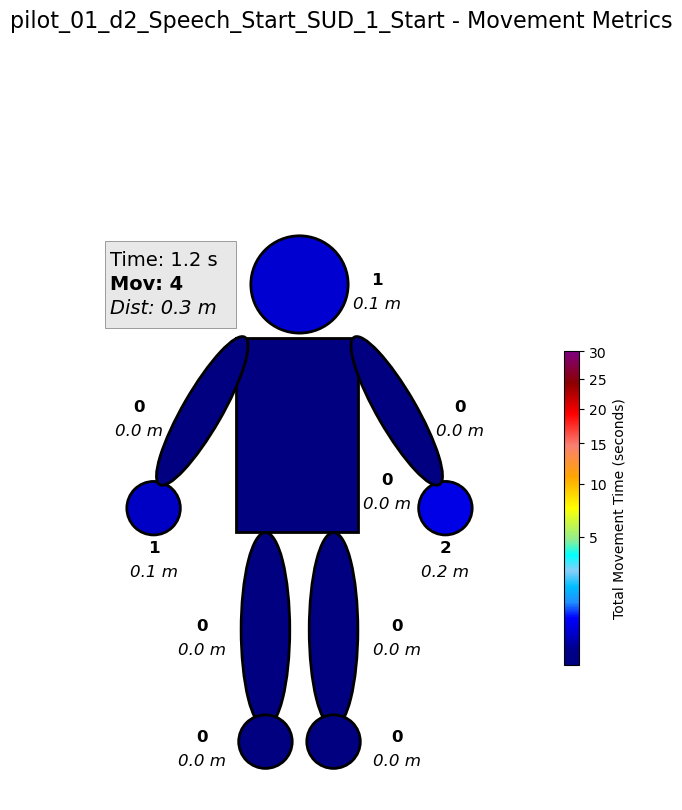

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d2_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Saved plot for pilot_01_d2_SUD_1_End_SUD_2_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_01_d2_SUD_1_End_SUD_2_Start_movement_metrics_plot.png


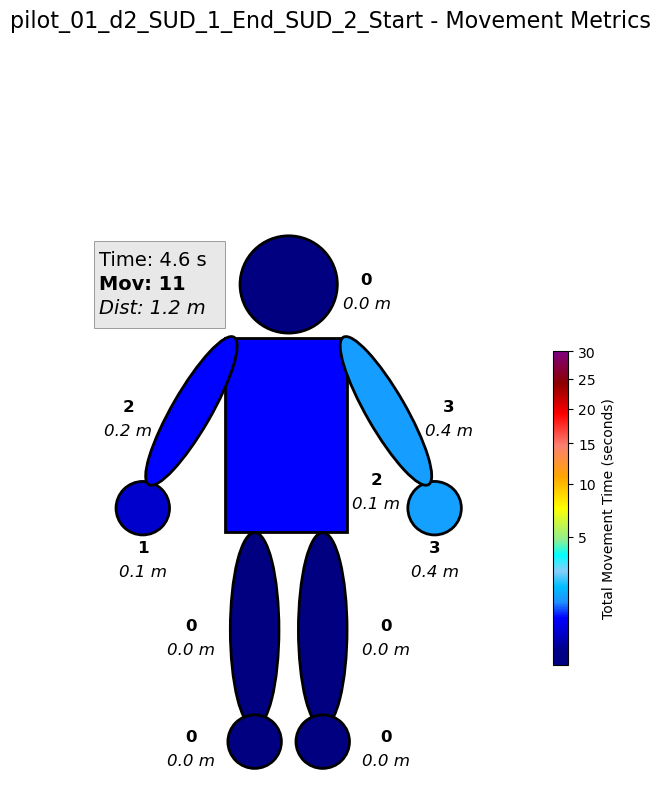

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d2_SUD_2_End_SUD_3_Start_combined_movement_metrics.csv
Saved plot for pilot_01_d2_SUD_2_End_SUD_3_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_01_d2_SUD_2_End_SUD_3_Start_movement_metrics_plot.png


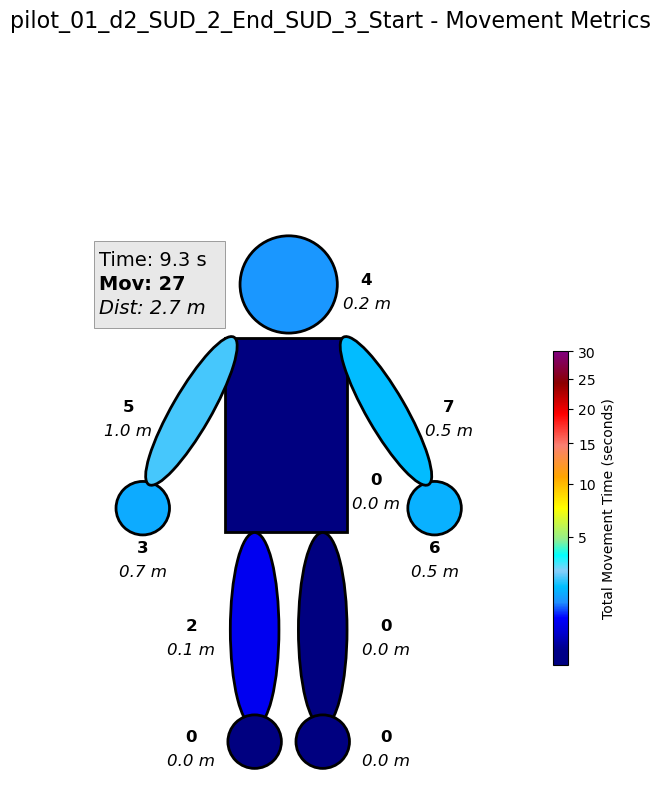

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d3_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Saved plot for pilot_01_d3_Speech_Start_SUD_1_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_01_d3_Speech_Start_SUD_1_Start_movement_metrics_plot.png


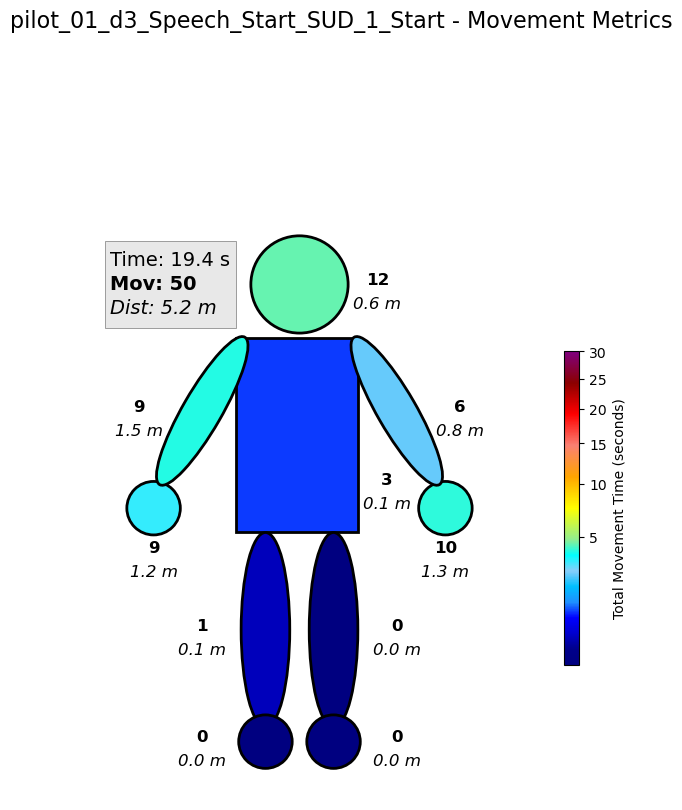

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d3_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Saved plot for pilot_01_d3_SUD_1_End_SUD_2_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_01_d3_SUD_1_End_SUD_2_Start_movement_metrics_plot.png


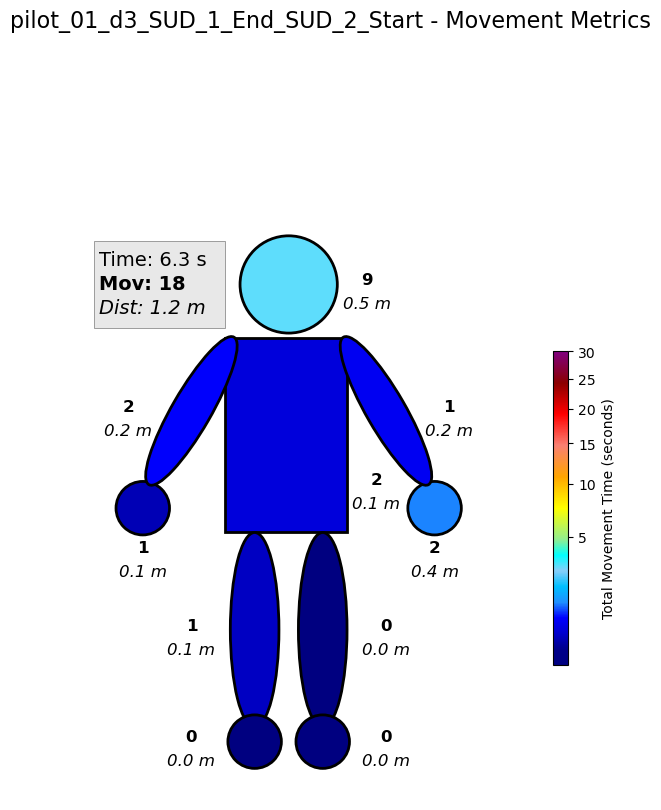

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d3_SUD_2_End_SUD_3_Start_combined_movement_metrics.csv
Saved plot for pilot_01_d3_SUD_2_End_SUD_3_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_01_d3_SUD_2_End_SUD_3_Start_movement_metrics_plot.png


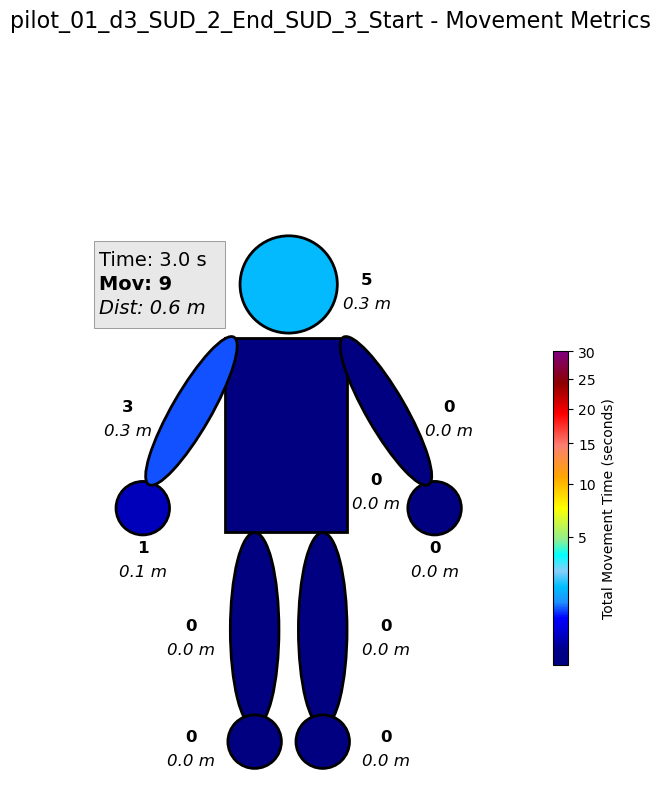

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_02_d2_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Saved plot for pilot_02_d2_Speech_Start_SUD_1_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_02_d2_Speech_Start_SUD_1_Start_movement_metrics_plot.png


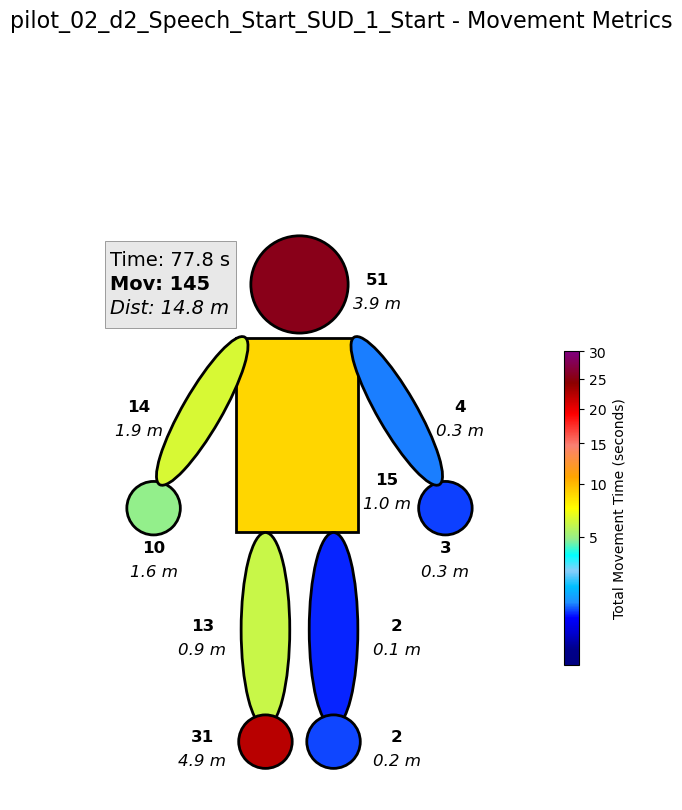

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_02_d2_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Saved plot for pilot_02_d2_SUD_1_End_SUD_2_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_02_d2_SUD_1_End_SUD_2_Start_movement_metrics_plot.png


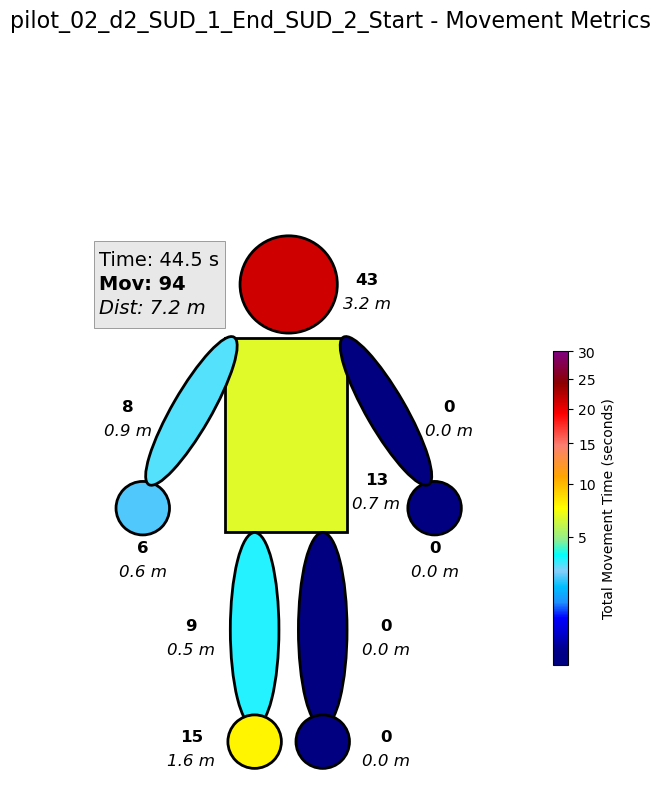

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_02_d2_SUD_2_End_SUD_3_Start_combined_movement_metrics.csv
Saved plot for pilot_02_d2_SUD_2_End_SUD_3_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_02_d2_SUD_2_End_SUD_3_Start_movement_metrics_plot.png


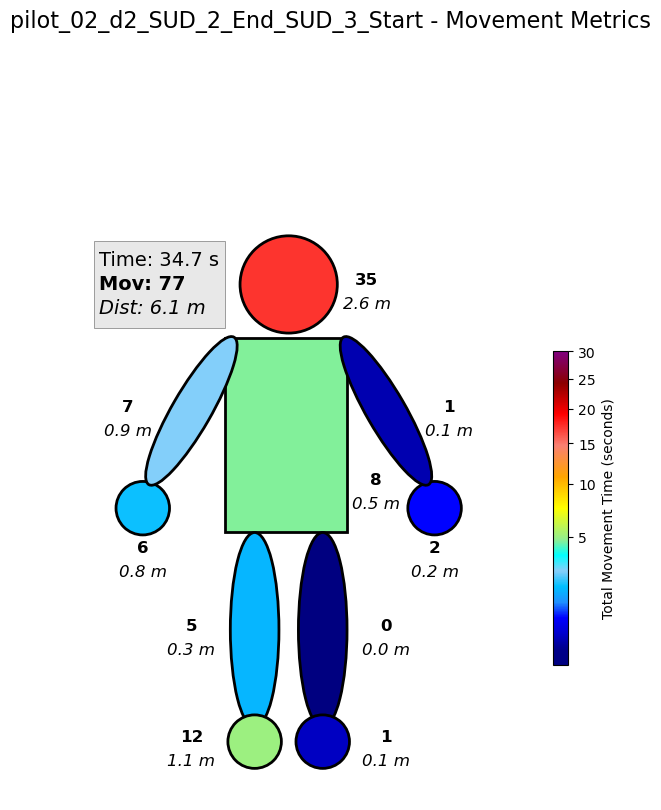

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_02_d3_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Saved plot for pilot_02_d3_Speech_Start_SUD_1_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_02_d3_Speech_Start_SUD_1_Start_movement_metrics_plot.png


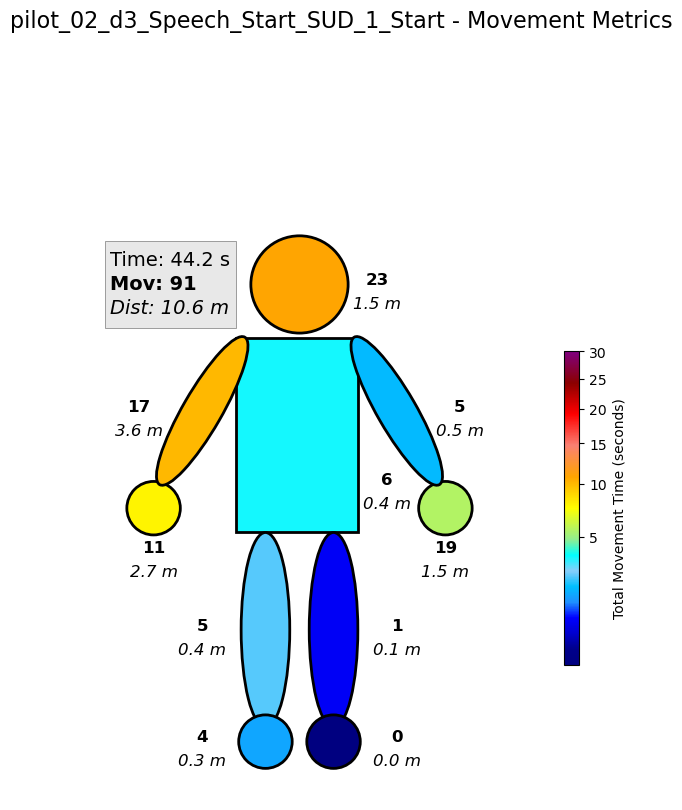

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_02_d3_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Saved plot for pilot_02_d3_SUD_1_End_SUD_2_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_02_d3_SUD_1_End_SUD_2_Start_movement_metrics_plot.png


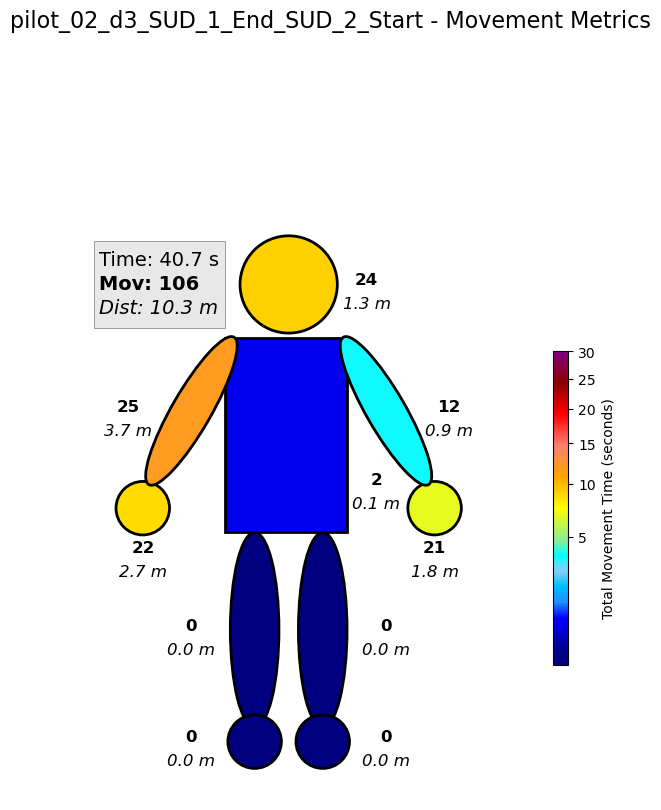

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_02_d3_SUD_2_End_SUD_3_Start_combined_movement_metrics.csv
Saved plot for pilot_02_d3_SUD_2_End_SUD_3_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_02_d3_SUD_2_End_SUD_3_Start_movement_metrics_plot.png


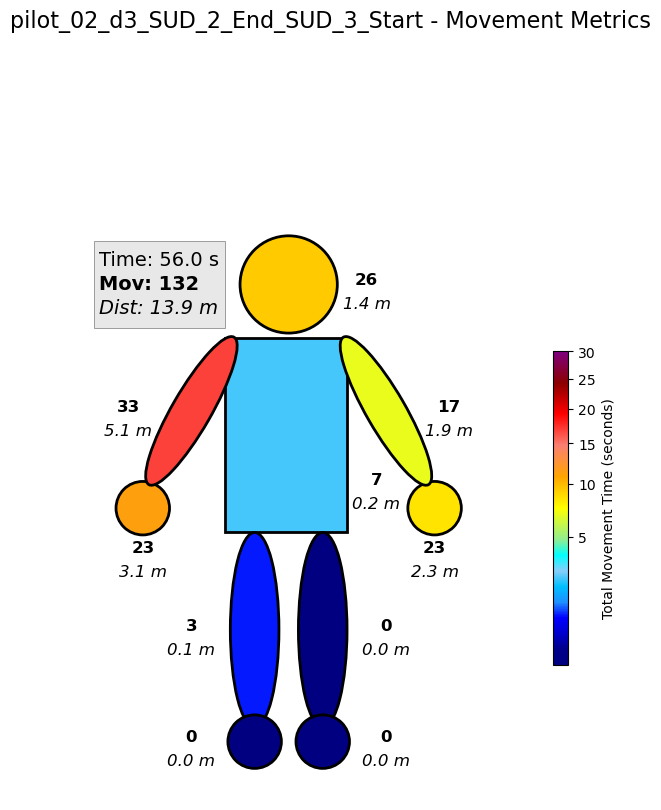

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_04_d2_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Saved plot for pilot_04_d2_Speech_Start_SUD_1_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_04_d2_Speech_Start_SUD_1_Start_movement_metrics_plot.png


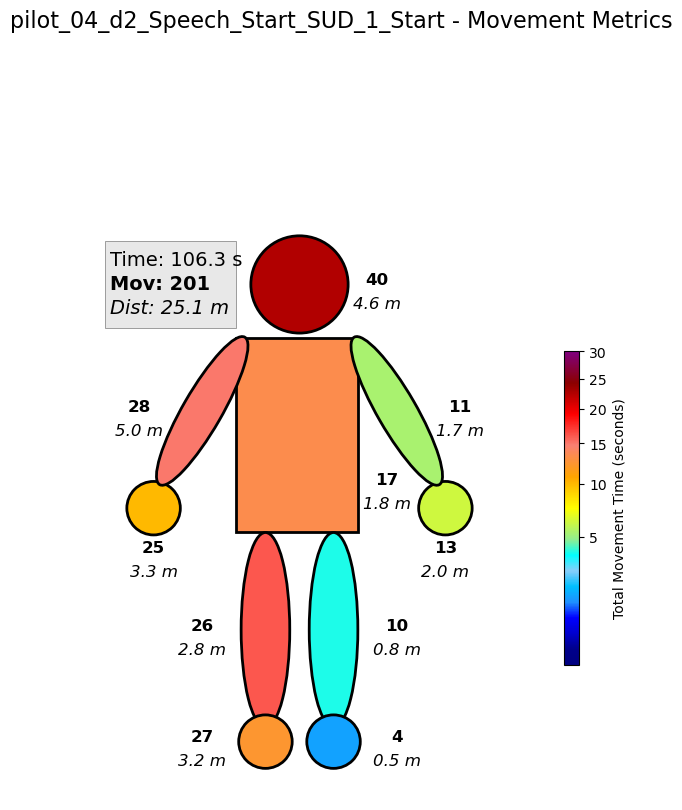

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_04_d2_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Saved plot for pilot_04_d2_SUD_1_End_SUD_2_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_04_d2_SUD_1_End_SUD_2_Start_movement_metrics_plot.png


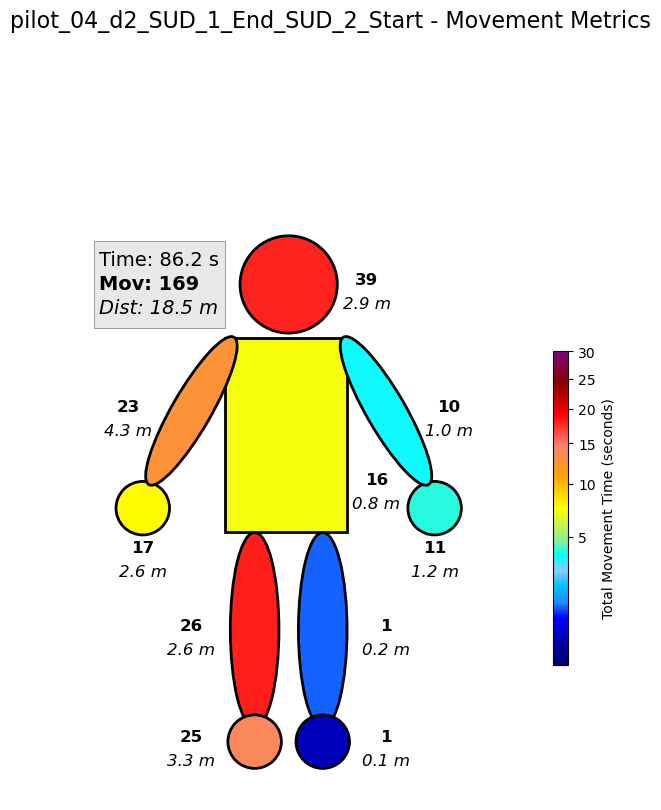

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_04_d2_SUD_2_End_SUD_3_Start_combined_movement_metrics.csv
Saved plot for pilot_04_d2_SUD_2_End_SUD_3_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_04_d2_SUD_2_End_SUD_3_Start_movement_metrics_plot.png


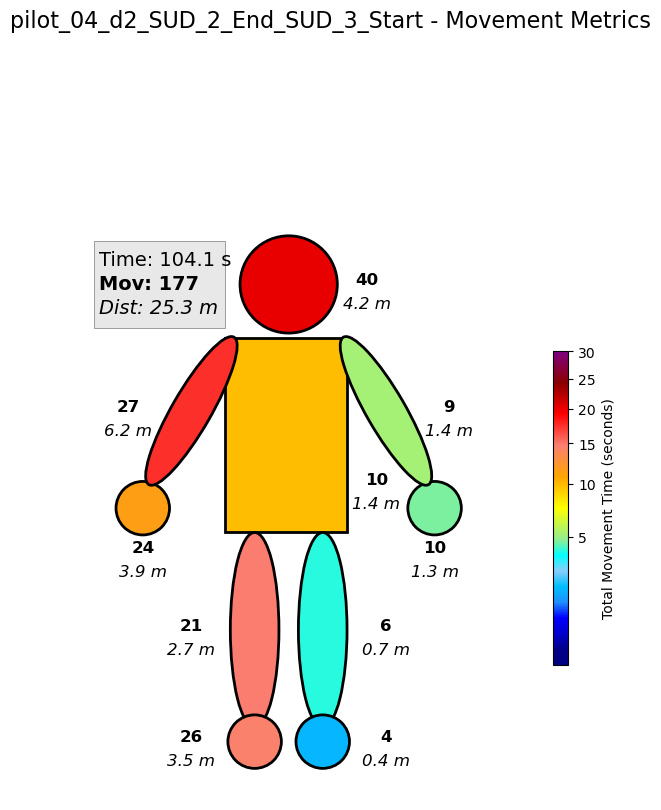

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_05_d2_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Saved plot for pilot_05_d2_Speech_Start_SUD_1_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_05_d2_Speech_Start_SUD_1_Start_movement_metrics_plot.png


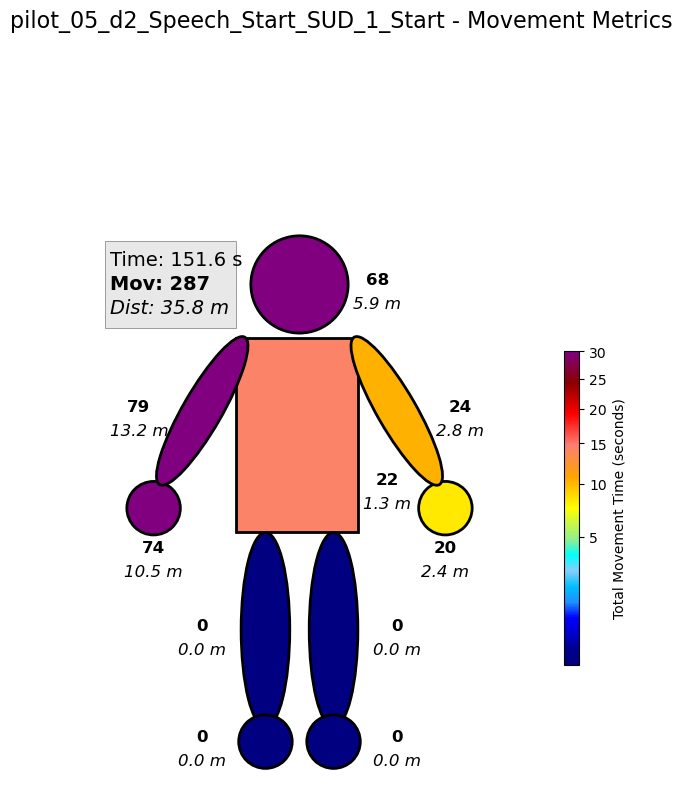

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_05_d2_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Saved plot for pilot_05_d2_SUD_1_End_SUD_2_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_05_d2_SUD_1_End_SUD_2_Start_movement_metrics_plot.png


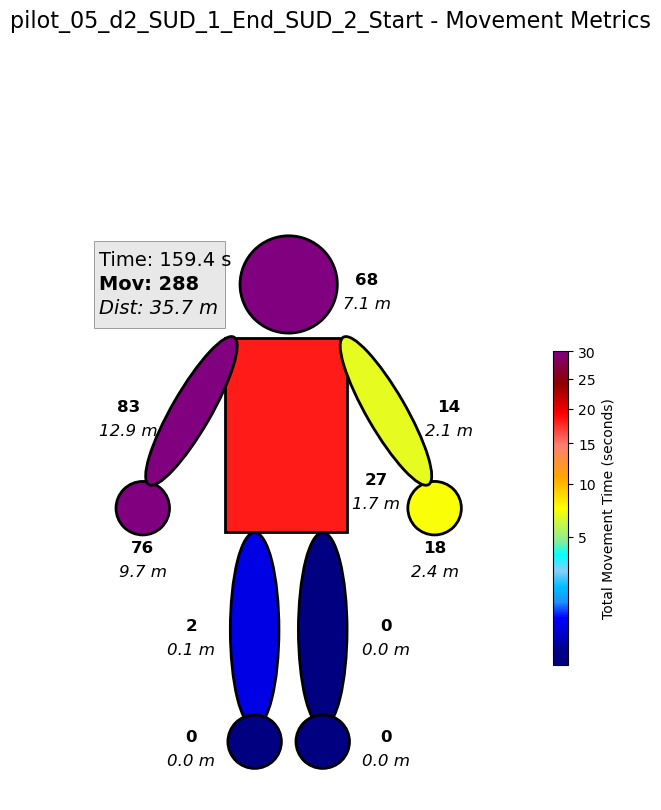

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_05_d2_SUD_2_End_SUD_3_Start_combined_movement_metrics.csv
Saved plot for pilot_05_d2_SUD_2_End_SUD_3_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_05_d2_SUD_2_End_SUD_3_Start_movement_metrics_plot.png


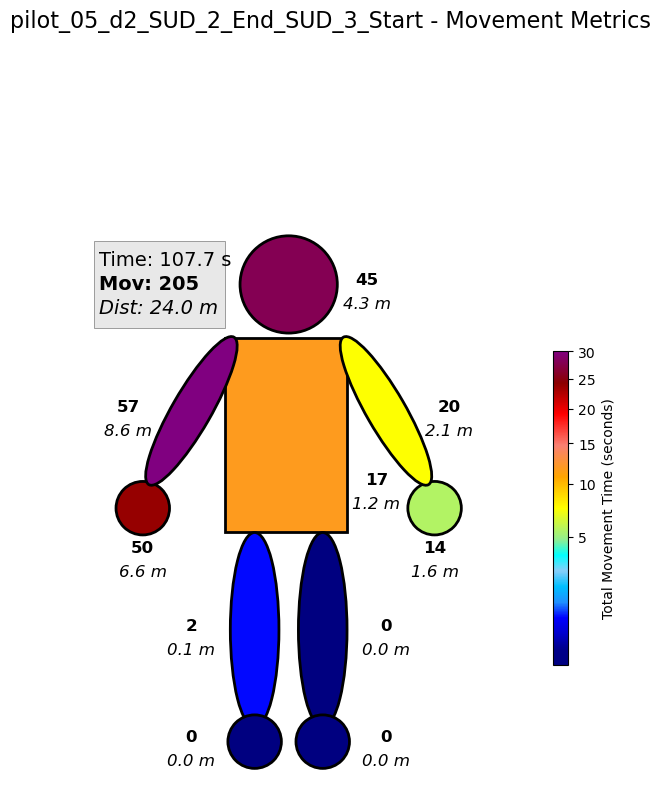

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_06_d2_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Saved plot for pilot_06_d2_Speech_Start_SUD_1_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_06_d2_Speech_Start_SUD_1_Start_movement_metrics_plot.png


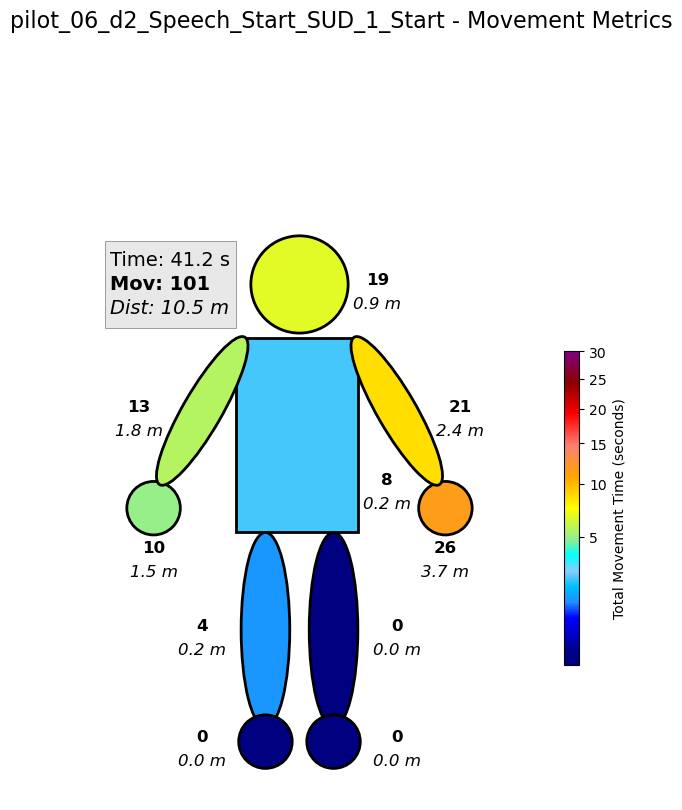

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_06_d2_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Saved plot for pilot_06_d2_SUD_1_End_SUD_2_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_06_d2_SUD_1_End_SUD_2_Start_movement_metrics_plot.png


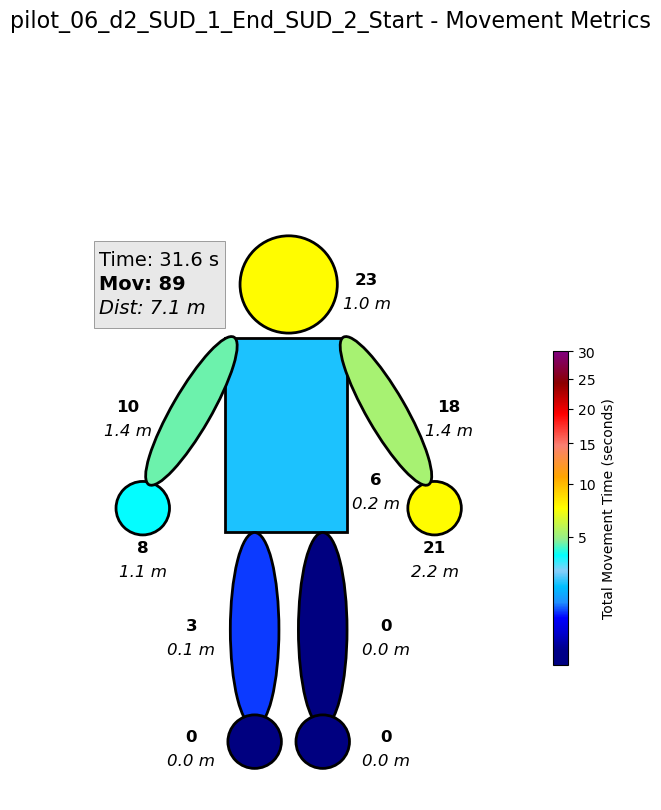

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_06_d2_SUD_2_End_SUD_3_Start_combined_movement_metrics.csv
Saved plot for pilot_06_d2_SUD_2_End_SUD_3_Start to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics\pilot_06_d2_SUD_2_End_SUD_3_Start_movement_metrics_plot.png


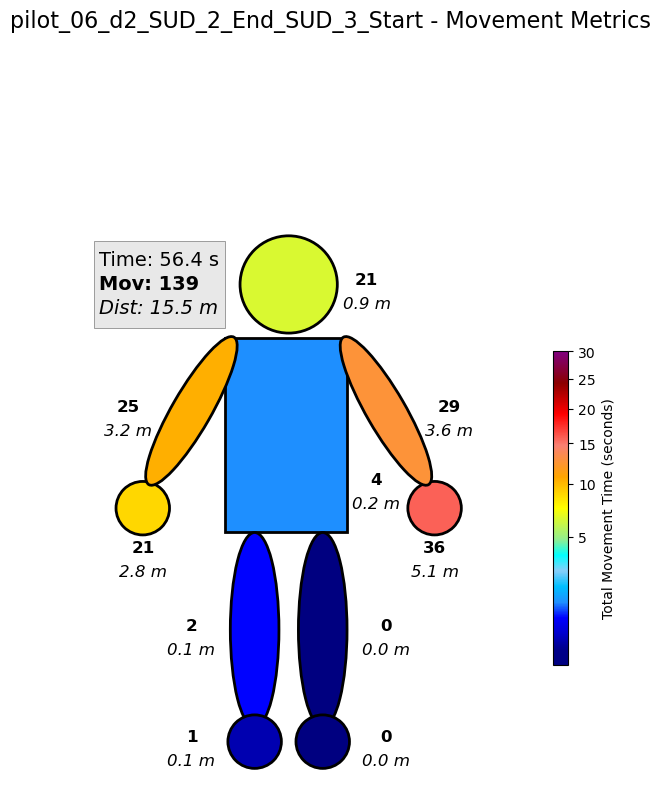

All files processed. Look into output directories for results


In [186]:
output_figures_metrics = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\figures_movement_metrics'

# Coordinates for body parts
# Coordinates for body parts
body_coords = {
    'group_face': (5, 10.6),
    'group_right_hand': (2, 6),
    'group_left_hand': (8, 6),
    'group_torso': (5.2, 7.5),
    'group_right_arm': (3, 8),
    'group_left_arm': (7, 8),
    'group_right_leg': (4.3, 3.5),
    'group_left_leg': (5.7, 3.5),
    'group_right_foot': (4.3, 1.2),
    'group_left_foot': (5.7, 1.2)
}


# Set the color map range (0 to 50 seconds)
min_time, max_time = 0.01, 30

# Custom colormap with more blues in the lower range and gradual transitions
custom_cmap = colors.LinearSegmentedColormap.from_list(
    'custom_coolwarm', 
    [(0, 'navy'), (0.05, 'darkblue'), (0.1, 'mediumblue'), (0.15, 'blue'),
     (0.2, 'dodgerblue'), (0.25, 'deepskyblue'), (0.3, 'lightskyblue'), 
     (0.35, 'cyan'), (0.4, 'lightgreen'), (0.5, 'yellow'), 
     (0.6, 'orange'), (0.7, 'salmon'), (0.8, 'red'), (0.9, 'darkred'), (1, 'purple')], 
    N=512  # Increase N to allow for more gradation
)

# Use PowerNorm to emphasize lower values
norm = PowerNorm(gamma=0.5, vmin=min_time, vmax=max_time)  # Adjust gamma to emphasize lower values

keyword = 'combined_movement_metrics.csv'

# Loop through each file in the directory
for root, dirs, files in os.walk(data_movement_metrics):
    for file in files:
        if file.endswith(keyword):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)  # Read the data from CSV
            print(f'Processing file: {file_path}')

            # Extract the base file name without the last part (_combined_movement_metrics.csv)
            fnam = os.path.basename(file_path).rsplit('_combined_movement_metrics.csv', 1)[0]


            # Sum the metrics across all body parts
            total_movement_time = math.ceil(data['Total Movement Time (s)'].sum() * 10) / 10
            total_movement_distance = math.ceil(data['Total Movement Distance (mm)'].sum() * 10) / 10
            total_movements = data['Number of Valid Movements'].sum()


            # Create a figure
            fig, ax = plt.subplots(figsize=(6, 10))
            fig.suptitle(f'{fnam} - Movement Metrics', fontsize=16)

            # Loop through body parts and plot their movement times
            for part, (x, y) in body_coords.items():
                if part in data['Landmark'].values:
                    # Extract movement time, movement distance, and number of movements for this body part
                    move_time = data.loc[data['Landmark'] == part, 'Total Movement Time (s)'].values[0]
                    move_distance = data.loc[data['Landmark'] == part, 'Total Movement Distance (mm)'].values[0]
                    num_movements = data.loc[data['Landmark'] == part, 'Number of Valid Movements'].values[0]

                    # Map movement time to color using the custom colormap and normalization
                    color = custom_cmap(norm(move_time))

                    if part == 'group_face':
                        # Plot face as a smaller circle
                        face = Circle((x, y), radius=1, color=color, ec='black', lw=2)
                        ax.add_patch(face)
                    elif part == 'group_torso':
                        # Plot torso as a rectangle
                        torso = Rectangle((x - 1.5, y - 2), width=2.5, height=4, color=color, ec='black', lw=2)
                        ax.add_patch(torso)
                    else:
                                # Plot arms, legs, hands, and feet
                                if 'arm' in part:
                                    ellipse = Ellipse((x, y), width=0.8, height=3.5, angle=-30 if 'right' in part else 30, color=color, ec='black', lw=2)
                                elif 'leg' in part:
                                    ellipse = Ellipse((x, y), width=1, height=4, angle=0, color=color, ec='black', lw=2)
                                elif 'hand' in part or 'foot' in part:
                                    ellipse = Circle((x, y), radius=0.55, color=color, ec='black', lw=2)
                                ax.add_patch(ellipse)


                    # Add annotations for movement distance and number of movements
                      # Adjust the annotation positions slightly to move them outside the shape
                    if 'face' in part:
                        offset_x = 1.6
                        offset_y = 0
                    elif 'torso' in part:
                        offset_x = 1.6
                        offset_y = -1
                    elif 'right' in part and 'hand' in part:
                        offset_x = 0
                        offset_y = -0.9
                    elif 'left' in part and 'hand' in part:
                        offset_x = 0
                        offset_y = -0.9
                    elif 'right' in part:
                        offset_x = -1.3
                        offset_y = 0
                    elif 'left' in part:
                        offset_x = 1.3
                        offset_y = 0

                    # Add annotations for movement distance and number of movements outside the shapes
                    ax.text(x + offset_x, y + offset_y, f'{int(num_movements)}', fontsize=12, fontweight = 'bold', color='black', ha='center')  
                    rounded_move_distance = math.ceil(move_distance * 10)/10
                    ax.text(x + offset_x, y + offset_y - 0.4, f'{rounded_move_distance:.1f} m', fontsize=12, fontstyle='italic', color='black', ha='center', va='center')

                    # ax.text(x + offset_x, y + offset_y, f'{move_distance:.2f} mm', fontsize=8, color='black', ha='center', va='center')  
                    # ax.text(x + offset_x, y + offset_y - 0.4, f'Num: {num_movements}', fontsize=8, color='black', ha='center')  


                    # ax.text(x, y, f'{move_distance:.2f} mm', fontsize=8, color='black', ha='center', va='center')  # Inside or below
                    # ax.text(x, y - 0.5, f'Num: {num_movements}', fontsize=8, color='black', ha='center')  # Next to the shape

             # Add total metrics as an annotation on the top of the figure
             # Define the coordinates and dimensions of the rectangle
            rect_x, rect_y = 1, 9.7  # Bottom-left corner of the rectangle
            rect_width, rect_height = 2.7, 1.8  # Width and height of the rectangle
            rect = Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=0.5, edgecolor='black', facecolor='lightgray', alpha=0.5)
            ax.add_patch(rect)
            ax.text(1.1, 11, f'Time: {total_movement_time:.1f} s', fontsize=14,  ha='left')
            ax.text(1.1, 10.5, f'Mov: {int(total_movements)}', fontsize=14, fontweight='bold', ha='left')
            ax.text(1.1, 10, f'Dist: {total_movement_distance:.1f} m', fontsize=14, fontstyle='italic', ha='left')


            # Add colorbar without 'cax=ax' to avoid layout issues
            cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax, fraction=0.03, pad=0.04)
            cbar.set_label('Total Movement Time (seconds)')

            # Set limits and remove axes for a clean look
            ax.set_xlim(0, 10)
            ax.set_ylim(0, 12)
            ax.set_aspect('equal')
            ax.axis('off')

            # Tighten the layout and save the figure
            plt.tight_layout()
            #plt.show()
            outputfile = os.path.join(output_figures_metrics, f'{fnam}_movement_metrics_plot.png')
            plt.savefig(outputfile,  dpi=300)
            print(f"Saved plot for {fnam} to {outputfile}")

            # Close the figure to release memory
            plt.show()

print("All files processed. Look into output directories for results")


### 6. Plotting HeatMaps for the Avearage participants across all data sets

Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d2_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d2_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d2_SUD_2_End_SUD_3_Start_combined_movement_metrics.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d3_Speech_Start_SUD_1_Start_combined_movement_metrics.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Movement_Derivative\data_movement_metrics\pilot_01_d3_SUD_1_End_SUD_2_Start_combined_movement_metrics.csv
Processing file: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\4_Mo

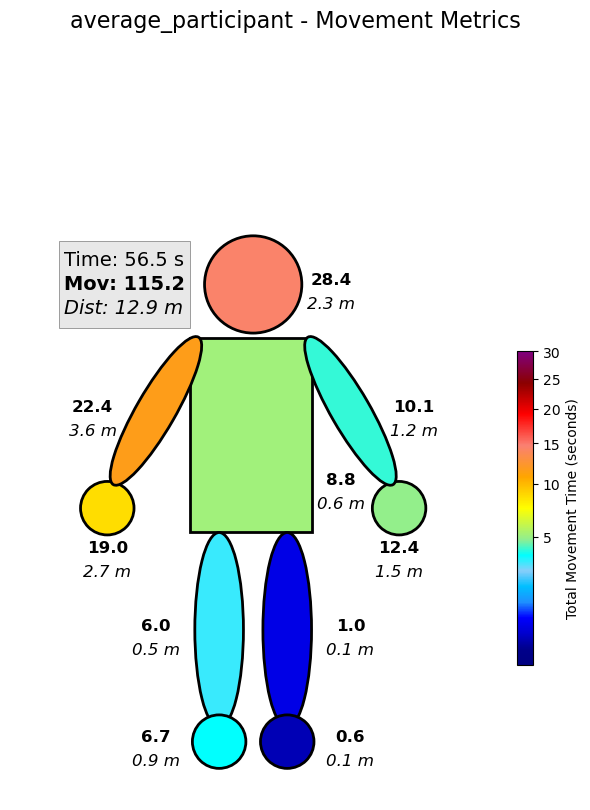

In [189]:
### 1. First we calculated the average movement metrics across all datasets for each landmark group ### 

# Initialize an empty DataFrame to accumulate the combined movement metrics
combined_movement_data = None
file_count = 0  # To keep track of the number of files

keyword = 'combined_movement_metrics.csv'   
fnam = 'average_participant'

# Loop through each file in the directory
for root, dirs, files in os.walk(data_movement_metrics):
    for file in files:
        if file.endswith('_combined_movement_metrics.csv'):  # Adjust the keyword if necessary
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)  # Read the data from CSV
            print(f'Processing file: {file_path}')
            
            if combined_movement_data is None:
                # Initialize with the first file's data
                combined_movement_data = data.copy()
            else:
                # Merge the data based on the 'Landmark' column, summing the relevant metrics
                combined_movement_data = combined_movement_data.merge(
                    data, 
                    on='Landmark', 
                    how='outer', 
                    suffixes=('', '_new')
                )

                # Sum the relevant columns
                combined_movement_data['Total Movement Time (s)'] += combined_movement_data['Total Movement Time (s)_new'].fillna(0)
                combined_movement_data['Total Movement Distance (mm)'] += combined_movement_data['Total Movement Distance (mm)_new'].fillna(0)
                combined_movement_data['Number of Valid Movements'] += combined_movement_data['Number of Valid Movements_new'].fillna(0)

                # Drop the extra columns used for merging
                combined_movement_data.drop(['Total Movement Time (s)_new', 
                                             'Total Movement Distance (mm)_new', 
                                             'Number of Valid Movements_new'], axis=1, inplace=True)

            # Increment the file counter
            file_count += 1

# Calculate the average by dividing the sums by the number of files
if file_count > 0:
    combined_movement_data['Total Movement Time (s)'] /= file_count
    combined_movement_data['Total Movement Distance (mm)'] /= file_count
    combined_movement_data['Number of Valid Movements'] /= file_count

    # Save the combined and averaged data to a CSV file
    output_file = os.path.join(data_movement_metrics, 'average_movement_metrics.csv')
    combined_movement_data.to_csv(output_file, index=False)

    print(f'Average movement metrics calculated and saved to: {output_file}')
else:
    print("No files were processed.")
    
    
    
## 2. NOW WE PLOT THE AVERAGE MOVEMENT METRICS ACROSS ALL DATASETS FOR EACH LANDMARK GROUP ##

data = pd.read_csv(output_file)  # Read the average movement metrics data 


# Sum the metrics across all body parts
total_movement_time = math.ceil(data['Total Movement Time (s)'].sum() * 10) / 10
total_movement_distance = math.ceil(data['Total Movement Distance (mm)'].sum() * 10) / 10
total_movements = data['Number of Valid Movements'].sum()


# Coordinates for body parts
body_coords = {
    'group_face': (5, 10.6),
    'group_right_hand': (2, 6),
    'group_left_hand': (8, 6),
    'group_torso': (5.2, 7.5),
    'group_right_arm': (3, 8),
    'group_left_arm': (7, 8),
    'group_right_leg': (4.3, 3.5),
    'group_left_leg': (5.7, 3.5),
    'group_right_foot': (4.3, 1.2),
    'group_left_foot': (5.7, 1.2)
}

# Set the color map range (0 to 50 seconds)
min_time, max_time = 0.01, 30

# Custom colormap with more blues in the lower range and gradual transitions
custom_cmap = colors.LinearSegmentedColormap.from_list(
    'custom_coolwarm', 
    [(0, 'navy'), (0.05, 'darkblue'), (0.1, 'mediumblue'), (0.15, 'blue'),
     (0.2, 'dodgerblue'), (0.25, 'deepskyblue'), (0.3, 'lightskyblue'), 
     (0.35, 'cyan'), (0.4, 'lightgreen'), (0.5, 'yellow'), 
     (0.6, 'orange'), (0.7, 'salmon'), (0.8, 'red'), (0.9, 'darkred'), (1, 'purple')], 
    N=512  # Increase N to allow for more gradation
)

# Use PowerNorm to emphasize lower values
norm = PowerNorm(gamma=0.5, vmin=min_time, vmax=max_time)  # Adjust gamma to emphasize lower values

 
fig, ax = plt.subplots(figsize=(6, 10))
fig.suptitle(f'{fnam} - Movement Metrics', fontsize=16)

# Loop through body parts and plot their movement times
for part, (x, y) in body_coords.items():
    if part in data['Landmark'].values:
        # Extract movement time, movement distance, and number of movements for this body part
        move_time = data.loc[data['Landmark'] == part, 'Total Movement Time (s)'].values[0]
        move_distance = data.loc[data['Landmark'] == part, 'Total Movement Distance (mm)'].values[0]
        num_movements = data.loc[data['Landmark'] == part, 'Number of Valid Movements'].values[0]

        # Map movement time to color using the custom colormap and normalization
        color = custom_cmap(norm(move_time))

        if part == 'group_face':
            # Plot face as a smaller circle
            face = Circle((x, y), radius=1, color=color, ec='black', lw=2)
            ax.add_patch(face)
        elif part == 'group_torso':
            # Plot torso as a rectangle
            torso = Rectangle((x - 1.5, y - 2), width=2.5, height=4, color=color, ec='black', lw=2)
            ax.add_patch(torso)
        else:
            # Plot arms, legs, hands, and feet
            if 'arm' in part:
                ellipse = Ellipse((x, y), width=0.8, height=3.5, angle=-30 if 'right' in part else 30, color=color, ec='black', lw=2)
            elif 'leg' in part:
                ellipse = Ellipse((x, y), width=1, height=4, angle=0, color=color, ec='black', lw=2)
            elif 'hand' in part or 'foot' in part:
                ellipse = Circle((x, y), radius=0.55, color=color, ec='black', lw=2)
            ax.add_patch(ellipse)

        # Add annotations for movement distance and number of movements
            # Adjust the annotation positions slightly to move them outside the shape
        if 'face' in part:
            offset_x = 1.6
            offset_y = 0
        elif 'torso' in part:
            offset_x = 1.6
            offset_y = -1
        elif 'right' in part and 'hand' in part:
            offset_x = 0
            offset_y = -0.9
        elif 'left' in part and 'hand' in part:
            offset_x = 0
            offset_y = -0.9
        elif 'right' in part:
            offset_x = -1.3
            offset_y = 0
        elif 'left' in part:
            offset_x = 1.3
            offset_y = 0

        # Add annotations for movement distance and number of movements outside the shapes
        ax.text(x + offset_x, y + offset_y, f'{num_movements:.1f}', fontsize=12, fontweight = 'bold', color='black', ha='center')  
        rounded_move_distance = math.ceil(move_distance * 10)/10
        ax.text(x + offset_x, y + offset_y - 0.4, f'{rounded_move_distance:.1f} m', fontsize=12, fontstyle='italic', color='black', ha='center', va='center')

        # ax.text(x + offset_x, y + offset_y, f'{move_distance:.2f} mm', fontsize=8, color='black', ha='center', va='center')  
        # ax.text(x + offset_x, y + offset_y - 0.4, f'Num: {num_movements}', fontsize=8, color='black', ha='center')  


        # ax.text(x, y, f'{move_distance:.2f} mm', fontsize=8, color='black', ha='center', va='center')  # Inside or below
        # ax.text(x, y - 0.5, f'Num: {num_movements}', fontsize=8, color='black', ha='center')  # Next to the shape
 # Add total metrics as an annotation on the top of the figure
    # Define the coordinates and dimensions of the rectangle
rect_x, rect_y = 1, 9.7  # Bottom-left corner of the rectangle
rect_width, rect_height = 2.7, 1.8  # Width and height of the rectangle
rect = Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=0.5, edgecolor='black', facecolor='lightgray', alpha=0.5)
ax.add_patch(rect)
ax.text(1.1, 11, f'Time: {total_movement_time:.1f} s', fontsize=14,  ha='left')
ax.text(1.1, 10.5, f'Mov: {total_movements:.1f}', fontsize=14, fontweight='bold', ha='left')
ax.text(1.1, 10, f'Dist: {total_movement_distance:.1f} m', fontsize=14, fontstyle='italic', ha='left')

# Add colorbar without 'cax=ax' to avoid layout issues
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Total Movement Time (seconds)')

# Set limits and remove axes for a clean look
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.set_aspect('equal')
ax.axis('off')

# Tighten the layout and save the figure
plt.tight_layout()
outputfile = os.path.join(output_figures_metrics, f'{fnam}_movement_metrics_plot.png')
plt.savefig(outputfile,  dpi=300)
print(f"Saved plot for {fnam} to {outputfile}")

# Close the figure to release memory
plt.show()



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle, Circle
import numpy as np
import os
import pandas as pd
from matplotlib.colors import LogNorm
from matplotlib import colors
from matplotlib import cm  # This imports the cm module for colormaps


# Coordinates for body parts
body_coords = {
    'group_face': (5, 10.6),
    'group_left_hand': (2, 6),
    'group_right_hand': (8, 6),
    'group_torso': (5.2, 7.5),
    'group_left_arm': (3, 8),
    'group_right_arm': (7, 8),
    'group_left_leg': (4.3, 3.5),
    'group_right_leg': (5.7, 3.5),
    'group_left_foot': (4.3, 1.2),
    'group_right_foot': (5.7, 1.2)
}

# Set the color map range (0 to 50 seconds)
min_time, max_time = 0.01, 30
cmap = plt.cm.coolwarm

keyword = 'combined_movement_metrics.csv'

# Loop through each file in the directory
for root, dirs, files in os.walk(data_movement_metrics):
    for file in files:
        if file.endswith(keyword):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)  # Read the data from CSV
            print(f'Processing file: {file_path}')

            # Extract the base file name without the last part (_combined_movement_metrics.csv)
            fnam = os.path.basename(file_path).rsplit('_combined_movement_metrics.csv', 1)[0]

            # Create a figure
            fig, ax = plt.subplots(figsize=(6, 10))
            fig.suptitle(f'{fnam} - Movement Metrics', fontsize=16)

            # Loop through body parts and plot their movement times
            for part, (x, y) in body_coords.items():
                if part in data['Landmark'].values:
                    # Extract movement time, movement distance, and number of movements for this body part
                    move_time = data.loc[data['Landmark'] == part, 'Total Movement Time (s)'].values[0]
                    move_distance = data.loc[data['Landmark'] == part, 'Total Movement Distance (mm)'].values[0]
                    num_movements = data.loc[data['Landmark'] == part, 'Number of Valid Movements'].values[0]
                    
                    # Map movement time to color without normalization
                    color = cmap(move_time / max_time)

                    if part == 'group_face':
                        # Plot face as a smaller circle
                        face = Circle((x, y), radius=1, color=color, ec='black', lw=2)
                        ax.add_patch(face)
                    elif part == 'group_torso':
                        # Plot torso as a rectangle
                        torso = Rectangle((x - 1.5, y - 2), width=2.5, height=4, color=color, ec='black', lw=2)
                        ax.add_patch(torso)
                    else:
                        # Plot arms, legs, hands, and feet
                        if 'arm' in part:
                            ellipse = Ellipse((x, y), width=0.8, height=3.5, angle=-30 if 'left' in part else 30, color=color, ec='black', lw=2)
                        elif 'leg' in part:
                            ellipse = Ellipse((x, y), width=1, height=4, angle=0, color=color, ec='black', lw=2)
                        elif 'hand' in part or 'foot' in part:
                            ellipse = Circle((x, y), radius=0.55, color=color, ec='black', lw=2)
                        ax.add_patch(ellipse)

                    # Add annotations for movement distance and number of movements
                    ax.text(x, y, f'{move_distance:.2f} mm', fontsize=8, color='black', ha='center', va='center')  # Inside or below
                    ax.text(x, y - 0.5, f'Num: {num_movements}', fontsize=8, color='black', ha='center')  # Next to the shape

            # Add colorbar to indicate the scale of movement times
            #sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_time, vmax=max_time))
            #sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=min_time, vmax=max_time))
            # Create the custom colormap
            custom_cmap = colors.LinearSegmentedColormap.from_list(
                'custom_coolwarm', 
                [(0, 'navy'), (0.05, 'darkblue'), (0.1, 'mediumblue'), (0.15, 'blue'),
                (0.2, 'dodgerblue'), (0.25, 'deepskyblue'), (0.3, 'lightskyblue'), 
                (0.35, 'cyan'), (0.4, 'lightgreen'), (0.5, 'yellow'), 
                (0.6, 'orange'), (0.7, 'salmon'), (0.8, 'red'), (0.9, 'darkred'), (1, 'purple')], 
                N=512  # Increase N to allow for more gradation
            )

            # Use PowerNorm to emphasize lower values
            norm = colors.PowerNorm(gamma=0.5, vmin=0, vmax=30)  # Adjust gamma to emphasize lower values

            # Plot the figure
            fig, ax = plt.subplots(figsize=(6, 10))

            # Add colorbar without specifying 'cax=ax' to avoid layout issues
            cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax, fraction=0.03, pad=0.04)
            cbar.set_label('Total Movement Time (seconds)')

            # Set limits and remove axes for a clean look
            ax.set_xlim(0, 10)
            ax.set_ylim(0, 12)
            ax.set_aspect('equal')
            ax.axis('off')

            # Tighten the layout and show
            plt.tight_layout()
            plt.show()


            # custom_cmap = colors.LinearSegmentedColormap.from_list(
            #     'custom_coolwarm', 
            #     [(0, 'navy'), (0.05, 'darkblue'), (0.1, 'mediumblue'), (0.15, 'blue'),
            #     (0.2, 'dodgerblue'), (0.25, 'deepskyblue'), (0.3, 'lightskyblue'), 
            #     (0.35, 'cyan'), (0.4, 'lightgreen'), (0.5, 'yellow'), 
            #     (0.6, 'orange'), (0.7, 'salmon'), (0.8, 'red'), (0.9, 'darkred'), (1, 'purple')], 
            #     N=512  # Increase N to allow for more gradation
            # )

            # # Use PowerNorm to apply more sensitivity to lower values (gamma < 1 compresses the upper range)
            # norm = colors.PowerNorm(gamma=0.5, vmin=0, vmax=30)  # Adjust gamma to emphasize lower v
            # cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax, orientation='horizontal')
            # cbar.set_label('Total Movement Time (seconds)')

            # # sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=min_time, vmax=max_time))
            # # sm.set_array([])
            # # cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
            # # cbar.set_label('Total Movement Time (seconds)')

            # # Set limits and remove axes for a clean look
            # ax.set_xlim(0, 10)
            # ax.set_ylim(0, 12)
            # ax.set_aspect('equal')
            # ax.axis('off')

            # Save the figure
            plt.tight_layout()
            outputfile = os.path.join(root, f'{fnam}_movement_metrics_plot.png')
            plt.savefig(outputfile)
            print(f"Saved plot for {fnam} to {outputfile}")

            # Display the plot (optional)
            plt.show()

            # Close the figure to release memory
            plt.close(fig)

print("All files processed. Look into output directories for results")
